In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *

In [2]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, processes=6, walltime='01:00:00')
w = cluster.scale(3*10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.135.39.32:33144' processes=30 threads=30, memory=500.10 GB>

_________

# Part 1 comparison

## 4.1. global-mean rotary spectra

### $E_{ageo}(\omega)$, $E_{geo}(\omega)$ and $E_{total}(\omega)$

In [6]:
#F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
F = [1,2,4,5,7,8,10,11]

In [7]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij), face=F ) 
ice

<xarray.DataArray 'AREA' (face: 8, j: 1080, i: 1080)>
dask.array<getitem, shape=(8, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 1 2 4 5 7 8 10 11
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

In [18]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

open_ocean_depth = 2000

for face in face_all:
    
    Efile = work_data_dir+'xy/Ageo_uv/E_ageo_uv_rescale_f%02d.zarr'%(face)

    ds = xr.open_zarr(work_data_dir+'xy/total_uv/E_uv_f%02d.zarr'%(face))
    chunks={'i': 188, 'j':192, 'freq_time':1440}
    ds = ds.chunk(chunks)     
    E = ds.uv
    
    # near-inertial
    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
    f_cpd_llc = f_llc*86400/2./np.pi  
    # rescaled by (omega/f)^2
    E_omega = E*((E.freq_time/f_cpd_llc)**2)
    E_omega = np.real(E_omega).rename('E_omega')
    
    # store
    E_omega = E_omega.to_dataset()
    #print(E_omega)
    #E_omega = E_omega.chunk({'i': 24*8, 'j':47*4})
    %time E_omega.to_zarr(Efile, mode='w')

    print('--- face %d done'%face)

CPU times: user 1.71 s, sys: 203 ms, total: 1.92 s
Wall time: 6.11 s
--- face 1 done
CPU times: user 1.73 s, sys: 241 ms, total: 1.97 s
Wall time: 6.04 s
--- face 2 done
CPU times: user 1.69 s, sys: 262 ms, total: 1.95 s
Wall time: 5.41 s
--- face 3 done
CPU times: user 1.95 s, sys: 262 ms, total: 2.21 s
Wall time: 6.59 s
--- face 4 done
CPU times: user 1.66 s, sys: 213 ms, total: 1.88 s
Wall time: 4.5 s
--- face 5 done
CPU times: user 1.73 s, sys: 237 ms, total: 1.96 s
Wall time: 5.97 s
--- face 6 done
CPU times: user 1.87 s, sys: 288 ms, total: 2.16 s
Wall time: 5.33 s
--- face 7 done
CPU times: user 1.72 s, sys: 231 ms, total: 1.95 s
Wall time: 6.19 s
--- face 8 done
CPU times: user 1.72 s, sys: 252 ms, total: 1.97 s
Wall time: 5.94 s
--- face 9 done
CPU times: user 1.67 s, sys: 232 ms, total: 1.9 s
Wall time: 4.89 s
--- face 10 done
CPU times: user 1.7 s, sys: 250 ms, total: 1.95 s
Wall time: 6.1 s
--- face 11 done
CPU times: user 1.71 s, sys: 228 ms, total: 1.93 s
Wall time: 5.85 

In [31]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

open_ocean_depth = 2000

for face in face_all:
    
    Efile = work_data_dir+'xy/Ageo_uv/E_ageo_uv_rescale2_f%02d.zarr'%(face)

    ds = xr.open_zarr(work_data_dir+'xy/total_uv/E_uv_f%02d.zarr'%(face))
    chunks={'i': 188, 'j':192, 'freq_time':1440}
    ds = ds.chunk(chunks)     
    E = ds.uv
    
    # near-inertial
    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
    f_cpd_llc = f_llc*86400/2./np.pi  
    # rescaled by (omega/f)^2
    E_omega = E*((1+E.freq_time/f_cpd_llc)**2)
    E_omega = np.real(E_omega).rename('E_omega')
    
    # store
    E_omega = E_omega.to_dataset()
    #print(E_omega)
    #E_omega = E_omega.chunk({'i': 24*8, 'j':47*4})
    %time E_omega.to_zarr(Efile, mode='w')

    print('--- face %d done'%face)

CPU times: user 1.77 s, sys: 204 ms, total: 1.98 s
Wall time: 6.7 s
--- face 0 done
CPU times: user 1.77 s, sys: 227 ms, total: 2 s
Wall time: 7.04 s
--- face 1 done
CPU times: user 1.99 s, sys: 218 ms, total: 2.21 s
Wall time: 6.64 s
--- face 2 done
CPU times: user 1.69 s, sys: 214 ms, total: 1.91 s
Wall time: 5.03 s
--- face 3 done
CPU times: user 1.77 s, sys: 204 ms, total: 1.97 s
Wall time: 6.31 s
--- face 4 done
CPU times: user 1.64 s, sys: 225 ms, total: 1.87 s
Wall time: 5.26 s
--- face 5 done
CPU times: user 1.75 s, sys: 229 ms, total: 1.97 s
Wall time: 6.18 s
--- face 6 done
CPU times: user 2 s, sys: 201 ms, total: 2.2 s
Wall time: 5.94 s
--- face 7 done
CPU times: user 1.72 s, sys: 213 ms, total: 1.94 s
Wall time: 6.63 s
--- face 8 done
CPU times: user 1.73 s, sys: 230 ms, total: 1.96 s
Wall time: 6.19 s
--- face 9 done
CPU times: user 1.68 s, sys: 224 ms, total: 1.91 s
Wall time: 5.11 s
--- face 10 done
CPU times: user 1.93 s, sys: 212 ms, total: 2.15 s
Wall time: 6.01 s
---

In [ ]:
F = [1,2,4,5,7,8,10,11]     

ds = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/E_ageo_uv_rescale_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')
E_omega = ds.E_omega

E_omega_mean = (E_omega.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC>10) & (ds.Depth>2000) & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))

E_omega_mean_2 = (E_omega.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC<-10) & (ds.Depth>2000)  & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))
E_omega_mean_2 = E_omega_mean_2.assign_coords(freq_time=E_omega_mean_2.freq_time * -1.) 

In [11]:
F = [1,2,4,5,7,8,10,11]

ds = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/E_ageo_uv_rescale2_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')
E_omega = ds.E_omega

E_omega2_mean = (E_omega.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC>10) & (ds.Depth>2000) & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))

E_omega2_mean_2 = (E_omega.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC<-10) & (ds.Depth>2000)  & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))
E_omega2_mean_2 = E_omega_mean_2.assign_coords(freq_time=E_omega_mean_2.freq_time * -1.) 

In [8]:
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/E_ageo_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')

E_ageo_uv_mean = (ds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC>10) & (ds.Depth>2000) & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))

E_ageo_uv_mean_2 = (ds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC<-10) & (ds.Depth>2000)  & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))
E_ageo_uv_mean_2 = E_ageo_uv_mean_2.assign_coords(freq_time=E_ageo_uv_mean_2.freq_time * -1.) 

In [9]:
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv/E_geo_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')

E_geo_uv_mean = (ds.uv_geo.isel(i=slice(1,-1),j=slice(1,-1)).where( (ds.YC>10) & (ds.Depth>2000)  & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))

E_geo_uv_mean_2 = (ds.uv_geo.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC<-10) & (ds.Depth>2000) & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))
E_geo_uv_mean_2 = E_geo_uv_mean_2.assign_coords(freq_time=E_geo_uv_mean_2.freq_time * -1.) 

In [10]:
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv/E_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')

E_total_uv_mean = (ds.uv.isel(i=slice(1,-1),j=slice(1,-1)).where( (ds.YC>10) & (ds.Depth>2000)  & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))

E_total_uv_mean_2 = (ds.uv.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC<-10) & (ds.Depth>2000)  & (ice>0) & (ds.j!=40) )).mean(dim=('i','j','face'))
E_total_uv_mean_2 = E_total_uv_mean_2.assign_coords(freq_time=E_total_uv_mean_2.freq_time * -1.) 

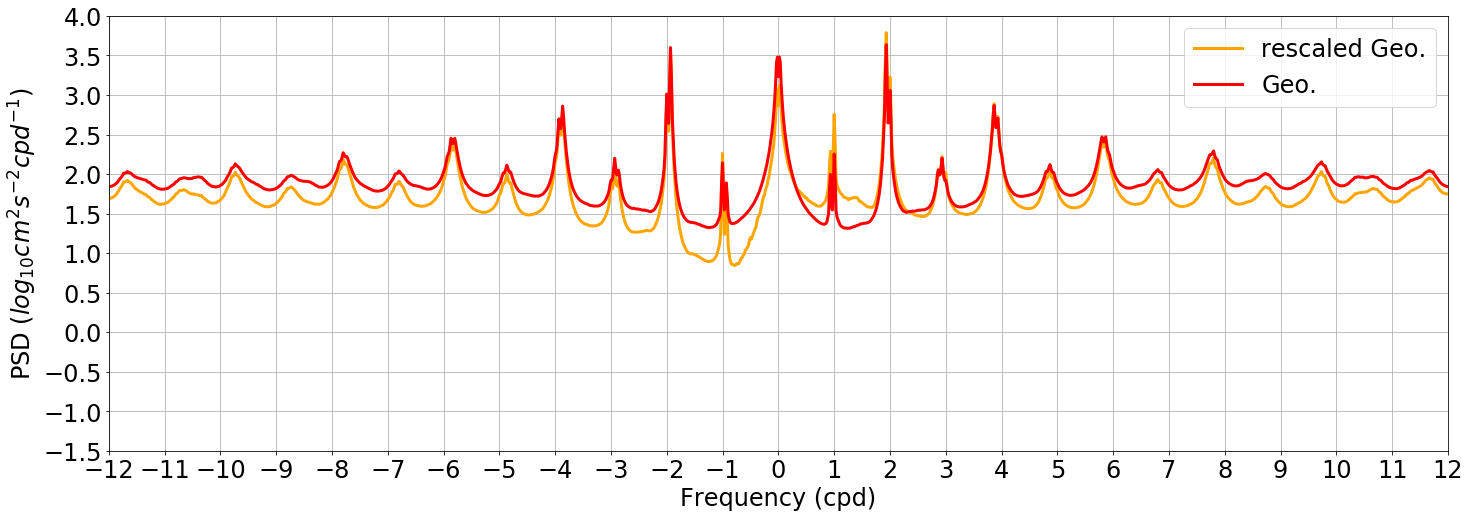

In [18]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['rescaled Geo.', 'Geo.']

(np.log10((E_omega2_mean_2+E_omega2_mean)*86400/2/6)).plot(ax=ax,color='orange', label=labels[0],linewidth=3)
(np.log10((E_geo_uv_mean_2+E_geo_uv_mean)*86400/2/6)).plot(ax=ax,color='red', label=labels[1],linewidth=3)


ax.grid()
ax.legend()
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5,-1,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_globalmean_spectra_geo.png')

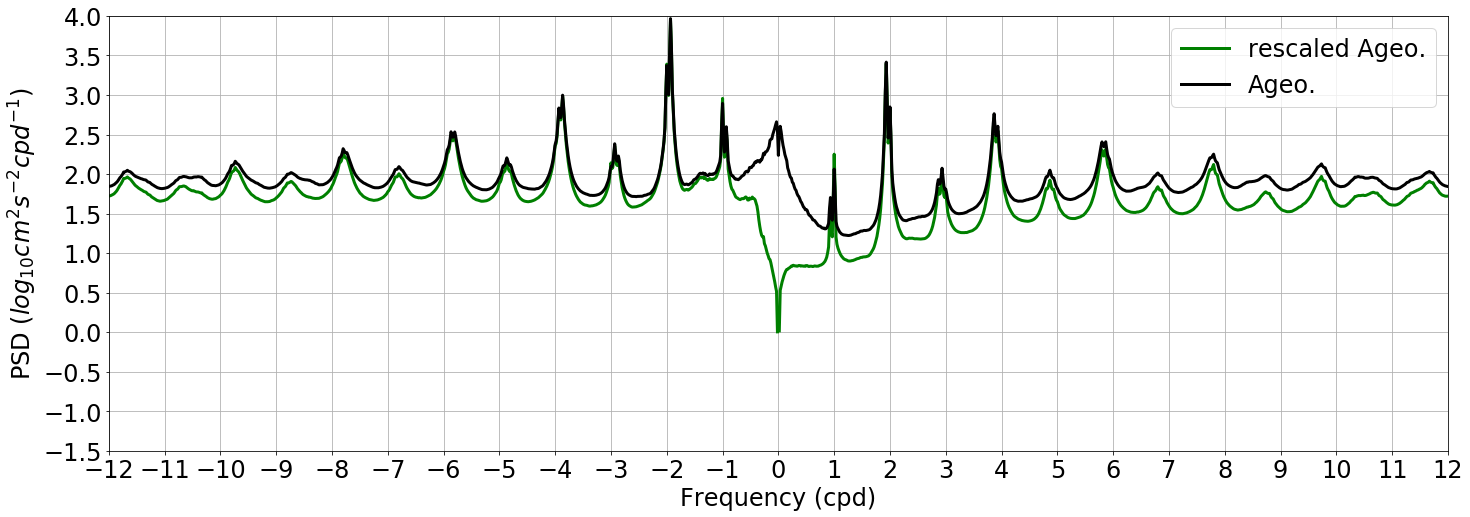

In [19]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['rescaled Ageo.', 'Ageo.']

(np.log10((E_omega_mean_2+E_omega_mean)*86400/2/6)).plot(ax=ax,color='green', label=labels[0],linewidth=3)
#(np.log10((E_omega2_mean_2+E_omega2_mean)*86400/2/6)).plot(ax=ax,color='blue', label=labels[0],linewidth=3)
(np.log10((E_ageo_uv_mean_2+E_ageo_uv_mean)*86400/2/6)).plot(ax=ax,color='black', label=labels[1],linewidth=3)

ax.grid()
ax.legend()
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5,-1,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_globalmean_spectra_ageo.png')

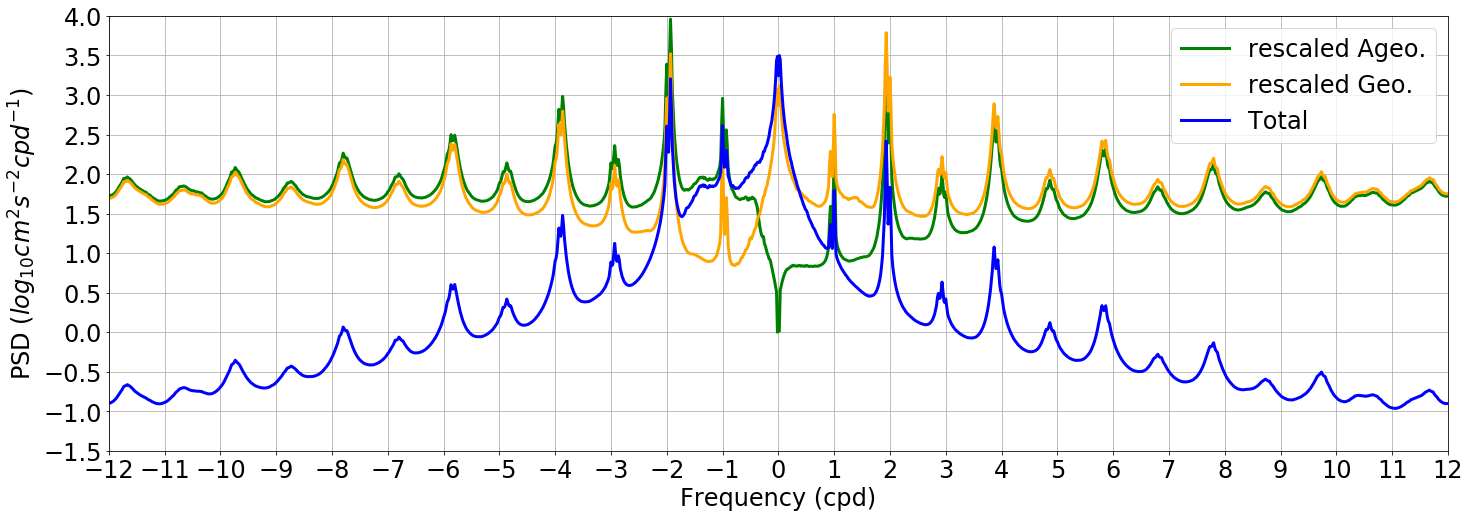

In [20]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['rescaled Ageo.', 'rescaled Geo.', 'Total']

(np.log10((E_omega_mean_2+E_omega_mean)*86400/2/6)).plot(ax=ax,color='green', label=labels[0],linewidth=3)
(np.log10((E_omega2_mean_2+E_omega2_mean)*86400/2/6)).plot(ax=ax,color='orange', label=labels[1],linewidth=3)
(np.log10((E_total_uv_mean_2+E_total_uv_mean)*86400/2/6)).plot(ax=ax,color='blue',label=labels[2],linewidth=3)
ax.grid()
ax.legend()
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5,-1,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_globalmean_spectra_total.png')

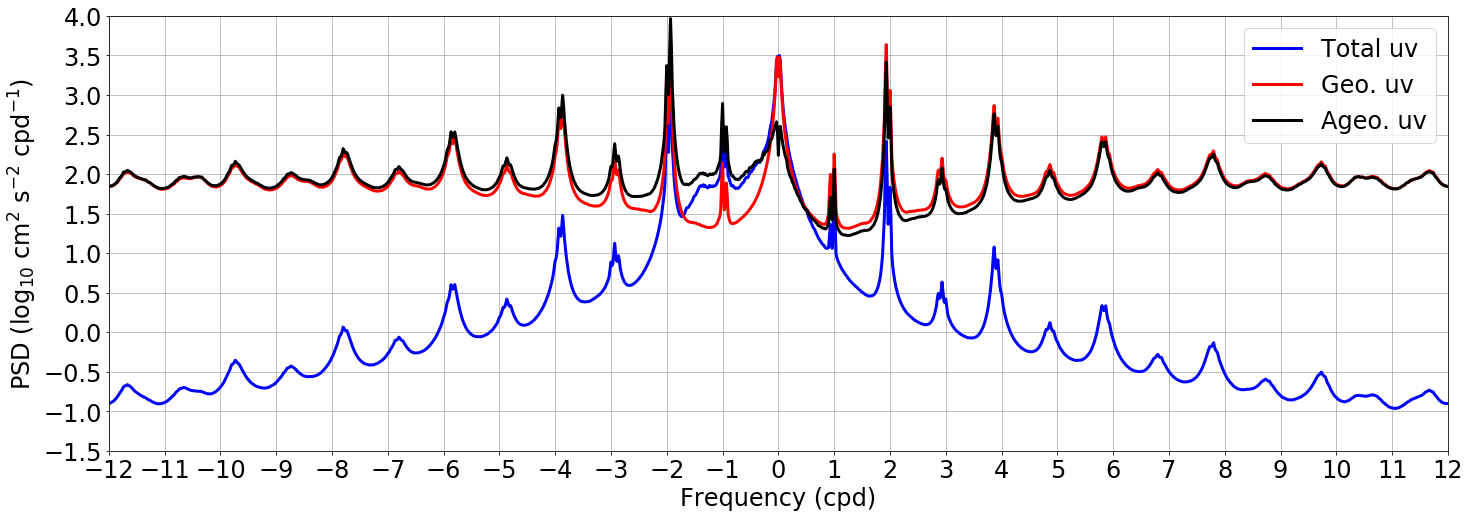

In [12]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Ageo. uv', 'Geo. uv', 'Total uv']

(np.log10((E_total_uv_mean_2+E_total_uv_mean)*86400/2/6)).plot(ax=ax,label=labels[2],color='blue',linewidth=3)
(np.log10((E_geo_uv_mean_2+E_geo_uv_mean)*86400/2/6)).plot(ax=ax,color='red', label=labels[1],linewidth=3)
(np.log10((E_ageo_uv_mean_2+E_ageo_uv_mean)*86400/2/6)).plot(ax=ax,color='black', label=labels[0],linewidth=3)
ax.grid()
ax.legend()
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5,-1,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_globalmean_spectra.png')

__________
## 4. 2. spectral comparison 
### $E_{ageo}(\omega, lat)$, $E_{geo}(\omega, lat)$ and $E_{total}(\omega, lat)$

In [5]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
v = 'uv_ageo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_ageo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_ageo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [6]:
v = 'uv'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv//%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_total_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_total_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [7]:
v = 'uv_geo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_geo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_geo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


Text(0.5, 0, 'Frequency (cpd)')

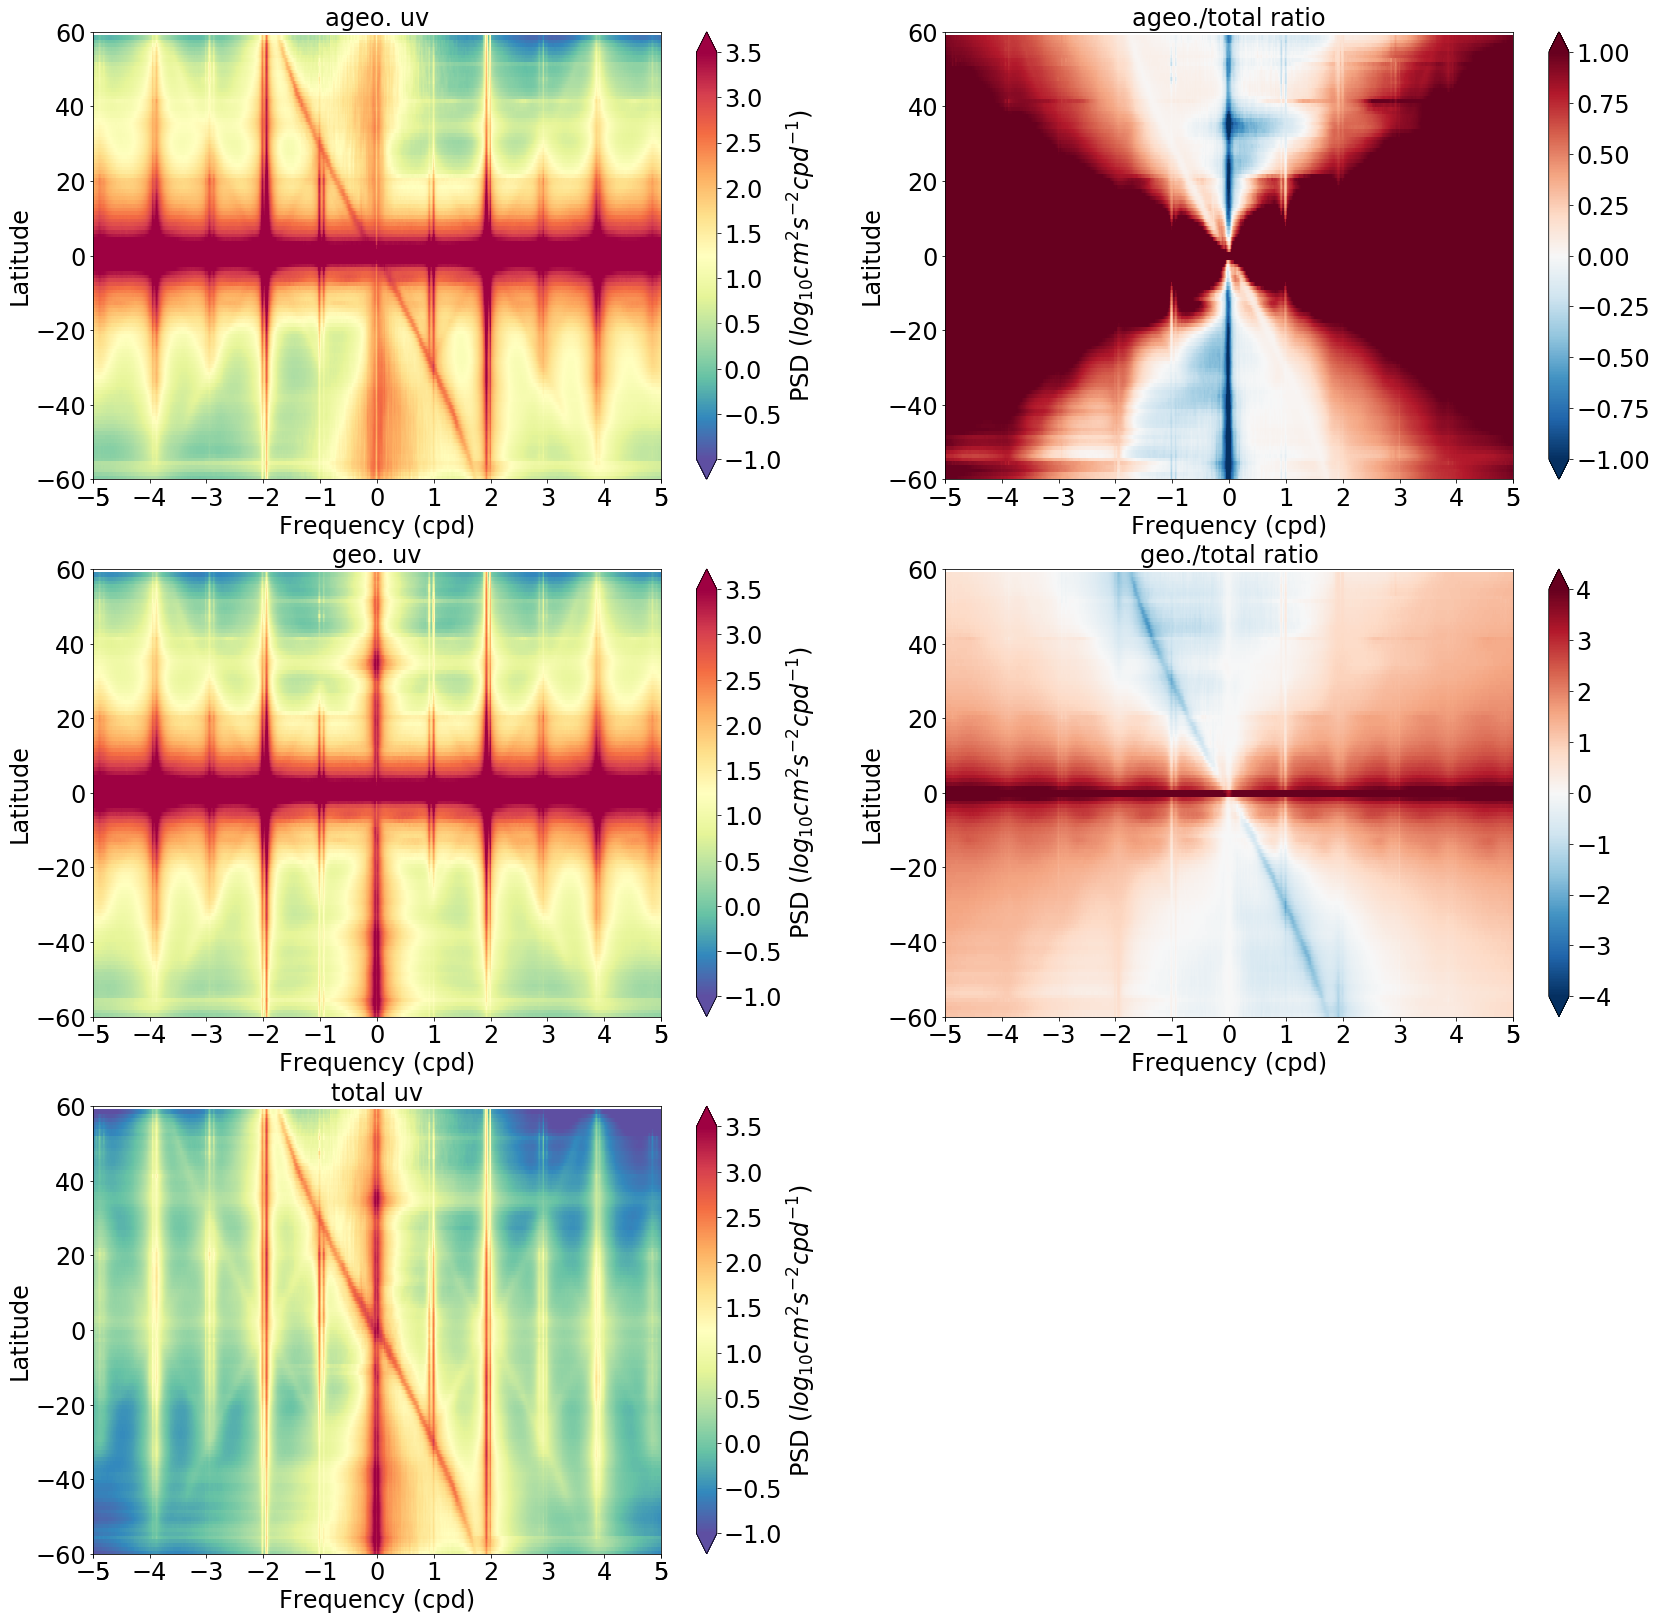

In [44]:
font_size = 24

fig, ax = plt.subplots(figsize=(28,28))

ax = plt.subplot(321)
cax=np.log10(E_ageo_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('ageo. uv',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax = plt.subplot(323)
cax=np.log10(E_geo_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('geo. uv',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax = plt.subplot(325)
cax=np.log10(E_total_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('total uv',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax = plt.subplot(322)
cax=np.log10(E_ageo_zav/E_total_zav).plot(vmin=-1, vmax=1, x='freq_time', y='latitude', cmap='RdBu_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('ageo./total ratio',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax = plt.subplot(324)
cax=np.log10(E_geo_zav/E_total_zav).plot(vmin=-4, vmax=4, x='freq_time', y='latitude', cmap='RdBu_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('geo./total ratio',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

#plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_zonalmean_spectra.png')

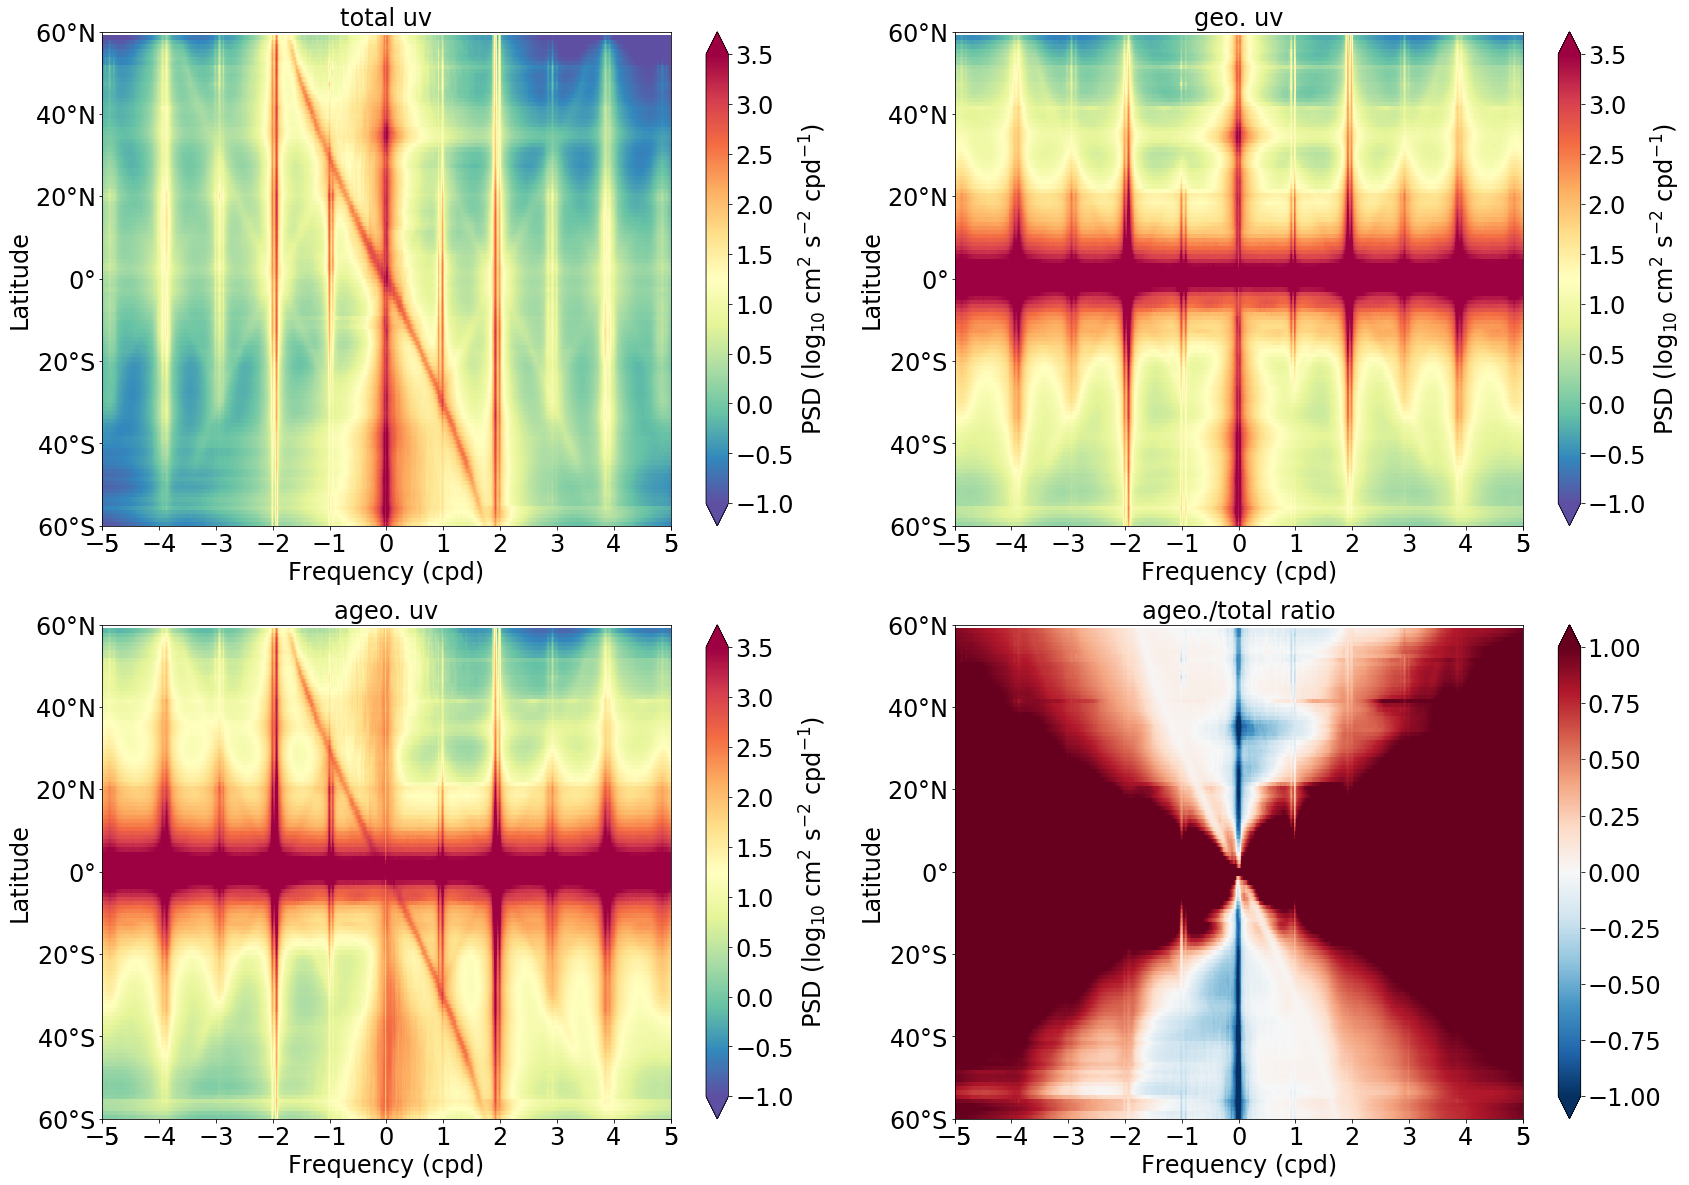

In [11]:
font_size = 24

fig, ax = plt.subplots(figsize=(28,20))

ax = plt.subplot(221)
cax=np.log10(E_total_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_title('total uv',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)


ax = plt.subplot(222)
cax=np.log10(E_geo_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_title('geo. uv',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)


ax = plt.subplot(223)
cax=np.log10(E_ageo_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_title('ageo. uv',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax = plt.subplot(224)
cax=np.log10(E_ageo_zav/E_total_zav).plot(vmin=-1, vmax=1, x='freq_time', y='latitude', cmap='RdBu_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_title('ageo./total ratio',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)


plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_zonalmean_spectra_20200525.png')

## 4.3 Spectral integrals (only for ageostrophic uv)


## low-freq $\int_{0}^{0.5 cpd} E_{ageo}(\omega, lat) d\omega$ vs.  high-freq $\int_{0.5 cpd}^{12 cpd} E_{ageo}(\omega, lat) d\omega$

In [45]:
df=E_ageo_zav.freq_time[1]-E_ageo_zav.freq_time[0]
df

<xarray.DataArray 'freq_time' ()>
array(0.01666667)

In [46]:
E_all = (E_ageo_zav*df).sum(dim='freq_time')
E_all = E_all.chunk({'latitude': 1}) 
E_all = np.real(E_all).rename('E_all')
E_all

<xarray.DataArray 'E_all' (latitude: 119)>
dask.array<real, shape=(119,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * latitude  (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5

In [47]:
E_high = (E_ageo_zav.where((abs(E_ageo_zav.freq_time)>0.5), other=0.)*df).sum(dim='freq_time')
E_high = E_high.chunk({'latitude': 1}) 
E_high = np.real(E_high).rename('E_high')
E_high

<xarray.DataArray 'E_high' (latitude: 119)>
dask.array<real, shape=(119,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * latitude  (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5

In [48]:
E_low = E_all - E_high
E_low = E_low.chunk({'latitude': 1}) 
E_low = np.real(E_low).rename('E_low')
E_low

<xarray.DataArray 'E_low' (latitude: 119)>
dask.array<real, shape=(119,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * latitude  (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5

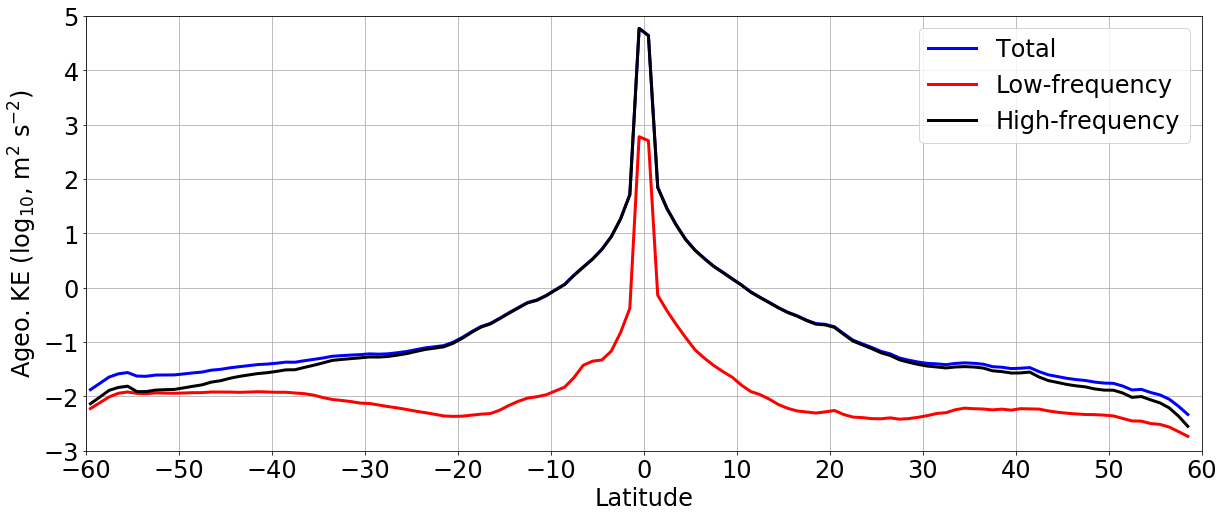

In [50]:
font_size = 24
labels = ['Total', 'Low-frequency', 'High-frequency']

fig, ax = plt.subplots(figsize=(20,8))

np.log10(E_all).plot(ax=ax,x='latitude',color='blue',label=labels[0],  linewidth=3)
np.log10(E_low).plot(ax=ax,x='latitude',color='red',label=labels[1],  linewidth=3)
np.log10(E_high).plot(ax=ax,x='latitude',color='black',label=labels[2], linewidth=3)

ax.grid()
ax.legend()
ax.set_ylim(-3., 5.)
ax.set_xlim(-60., 60.)
ax.set_yticks([-3, -2, -1, 0., 1., 2., 3., 4., 5.])
ax.set_xticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])

ax.legend(prop={'size': 24})
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Ageo. KE (log$_{10}$, m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_ageo_log.png')

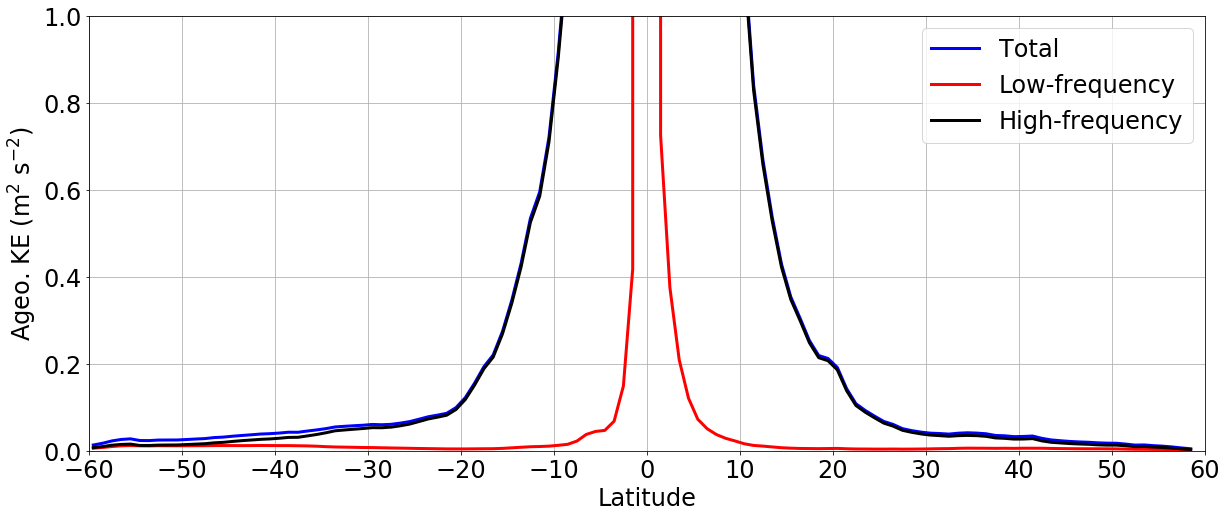

In [52]:
font_size = 24
labels = ['Total', 'Low-frequency', 'High-frequency']

fig, ax = plt.subplots(figsize=(20,8))

(E_all).plot(ax=ax,x='latitude',color='blue',label=labels[0],  linewidth=3)
(E_low).plot(ax=ax,x='latitude',color='red',label=labels[1],  linewidth=3)
(E_high).plot(ax=ax,x='latitude',color='black',label=labels[2], linewidth=3)

ax.grid()
ax.legend()
ax.set_ylim(0, 1.)
ax.set_xlim(-60., 60.)
#ax.set_yticks([-3, -2, -1, 0., 1., 2., 3., 4., 5.])
ax.set_xticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])

ax.legend(prop={'size': 24})
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Ageo. KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_ageo.png')

_________________
# 2. Read face 1

In [31]:
dsu = xr.open_zarr(work_data_dir+'xy/comparison/u_f01.zarr')
dsv = xr.open_zarr(work_data_dir+'xy/comparison/v_f01.zarr')

# KE_RMS
u_mean = (dsu['u']**2).mean(['time'])
u_mean = u_mean.persist()

u_geo_mean = (dsu['u_geo']**2).mean(['time'])
u_geo_mean = u_geo_mean.persist()

u_ageo_mean = (dsu['u_ageo']**2).mean(['time'])
u_ageo_mean = u_ageo_mean.persist()

v_mean = (dsv['v']**2).mean(['time'])
v_mean = v_mean.persist()

v_geo_mean = (dsv['v_geo']**2).mean(['time'])
v_geo_mean = v_geo_mean.persist()

v_ageo_mean = (dsv['v_ageo']**2).mean(['time'])
v_ageo_mean = v_ageo_mean.persist()

In [8]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
lice = ice.isel(face=1)
lice

<xarray.DataArray 'AREA' (j: 1080, i: 1080)>
dask.array<getitem, shape=(1080, 1080), dtype=float64, chunksize=(1080, 1080), chunktype=numpy.ndarray>
Coordinates:
    face     int64 1
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

Text(0.5, 1.0, 'ageo.v')

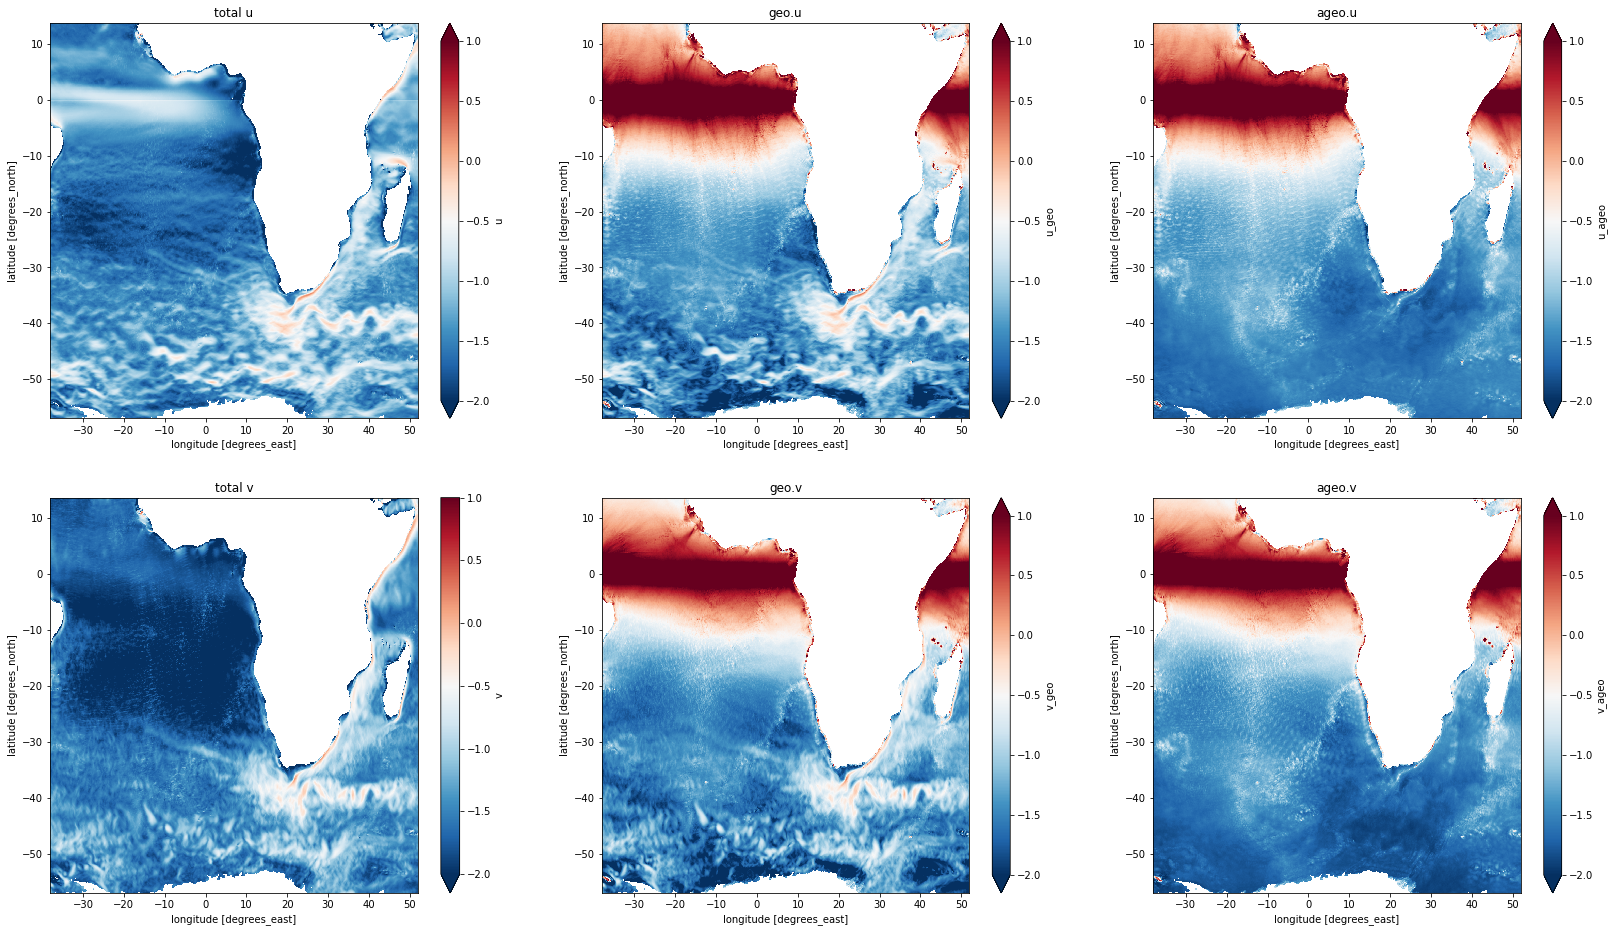

In [17]:
# in log scale
font_size = 12

fig, ax = plt.subplots(figsize = (28,16))

ax = plt.subplot(231)
np.log10(u_mean.where(lice>0)).plot(vmin=-2, vmax=1,x='XC', y='YC', cmap='RdBu_r')
ax.set_title('total u',fontsize=font_size)

ax = plt.subplot(232)
np.log10(u_geo_mean.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('geo.u',fontsize=font_size)

ax = plt.subplot(233)
np.log10(u_ageo_mean.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('ageo.u',fontsize=font_size)

ax = plt.subplot(234)
np.log10(v_mean.where(lice>0)).plot(vmin=-2, vmax=1,x='XC', y='YC', cmap='RdBu_r')
ax.set_title('total v',fontsize=font_size)

ax = plt.subplot(235)
np.log10(v_geo_mean.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('geo.v',fontsize=font_size)

ax = plt.subplot(236)
np.log10(v_ageo_mean.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('ageo.v',fontsize=font_size)

Text(0.5, 1.0, 'ageo.v')

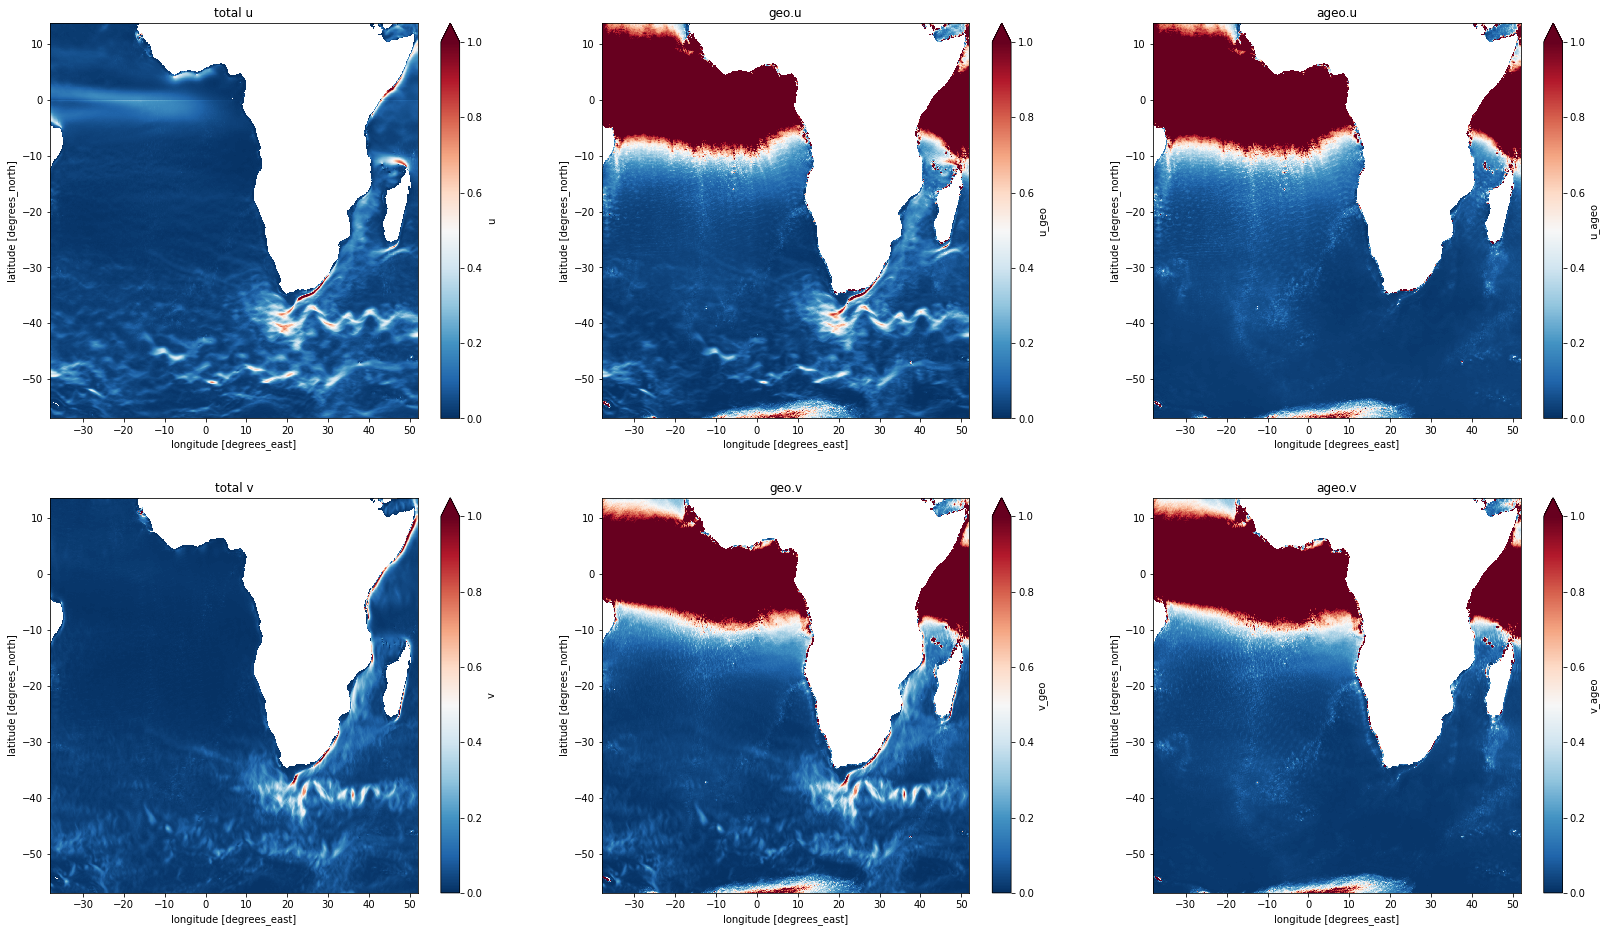

In [9]:
# in normal scale
font_size = 12

fig, ax = plt.subplots(figsize = (28,16))

ax = plt.subplot(231)
u_mean.plot(vmin=0, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('total u',fontsize=font_size)

ax = plt.subplot(232)
u_geo_mean.plot(vmin=0, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('geo.u',fontsize=font_size)

ax = plt.subplot(233)
u_ageo_mean.plot(vmin=0, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('ageo.u',fontsize=font_size)

ax = plt.subplot(234)
v_mean.plot(vmin=0, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('total v',fontsize=font_size)

ax = plt.subplot(235)
v_geo_mean.plot(vmin=0, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('geo.v',fontsize=font_size)

ax = plt.subplot(236)
v_ageo_mean.plot(vmin=0, vmax=1, x='XC', y='YC', cmap='RdBu_r')
ax.set_title('ageo.v',fontsize=font_size)

### to compare uv, geo-uv and ageo-uv estimated from model itself and spectra (with and without windowing/detrending)

In [5]:
# no windowing and detrending

D = xr.open_zarr(work_data_dir+'xy/Ageo_uv_all/E_band_integral_f01.zarr')
E_ageo_all = D.E_all

D = xr.open_zarr(work_data_dir+'xy/geo_uv_all/E_band_integral_f01.zarr')
E_geo_all = D.E_all

D = xr.open_zarr(work_data_dir+'xy/total_uv_all/E_band_integral_f01.zarr')
E_total_all = D.E_all

In [6]:
# with windowing and detrending

D = xr.open_zarr(work_data_dir+'xy/Ageo_uv/E_band_integral_f01.zarr')
E_ageo = D.E_all

D = xr.open_zarr(work_data_dir+'xy/geo_uv/E_band_integral_f01.zarr')
E_geo = D.E_all

D = xr.open_zarr(work_data_dir+'xy/total_uv/E_band_integral_f01.zarr')
E_total = D.E_all

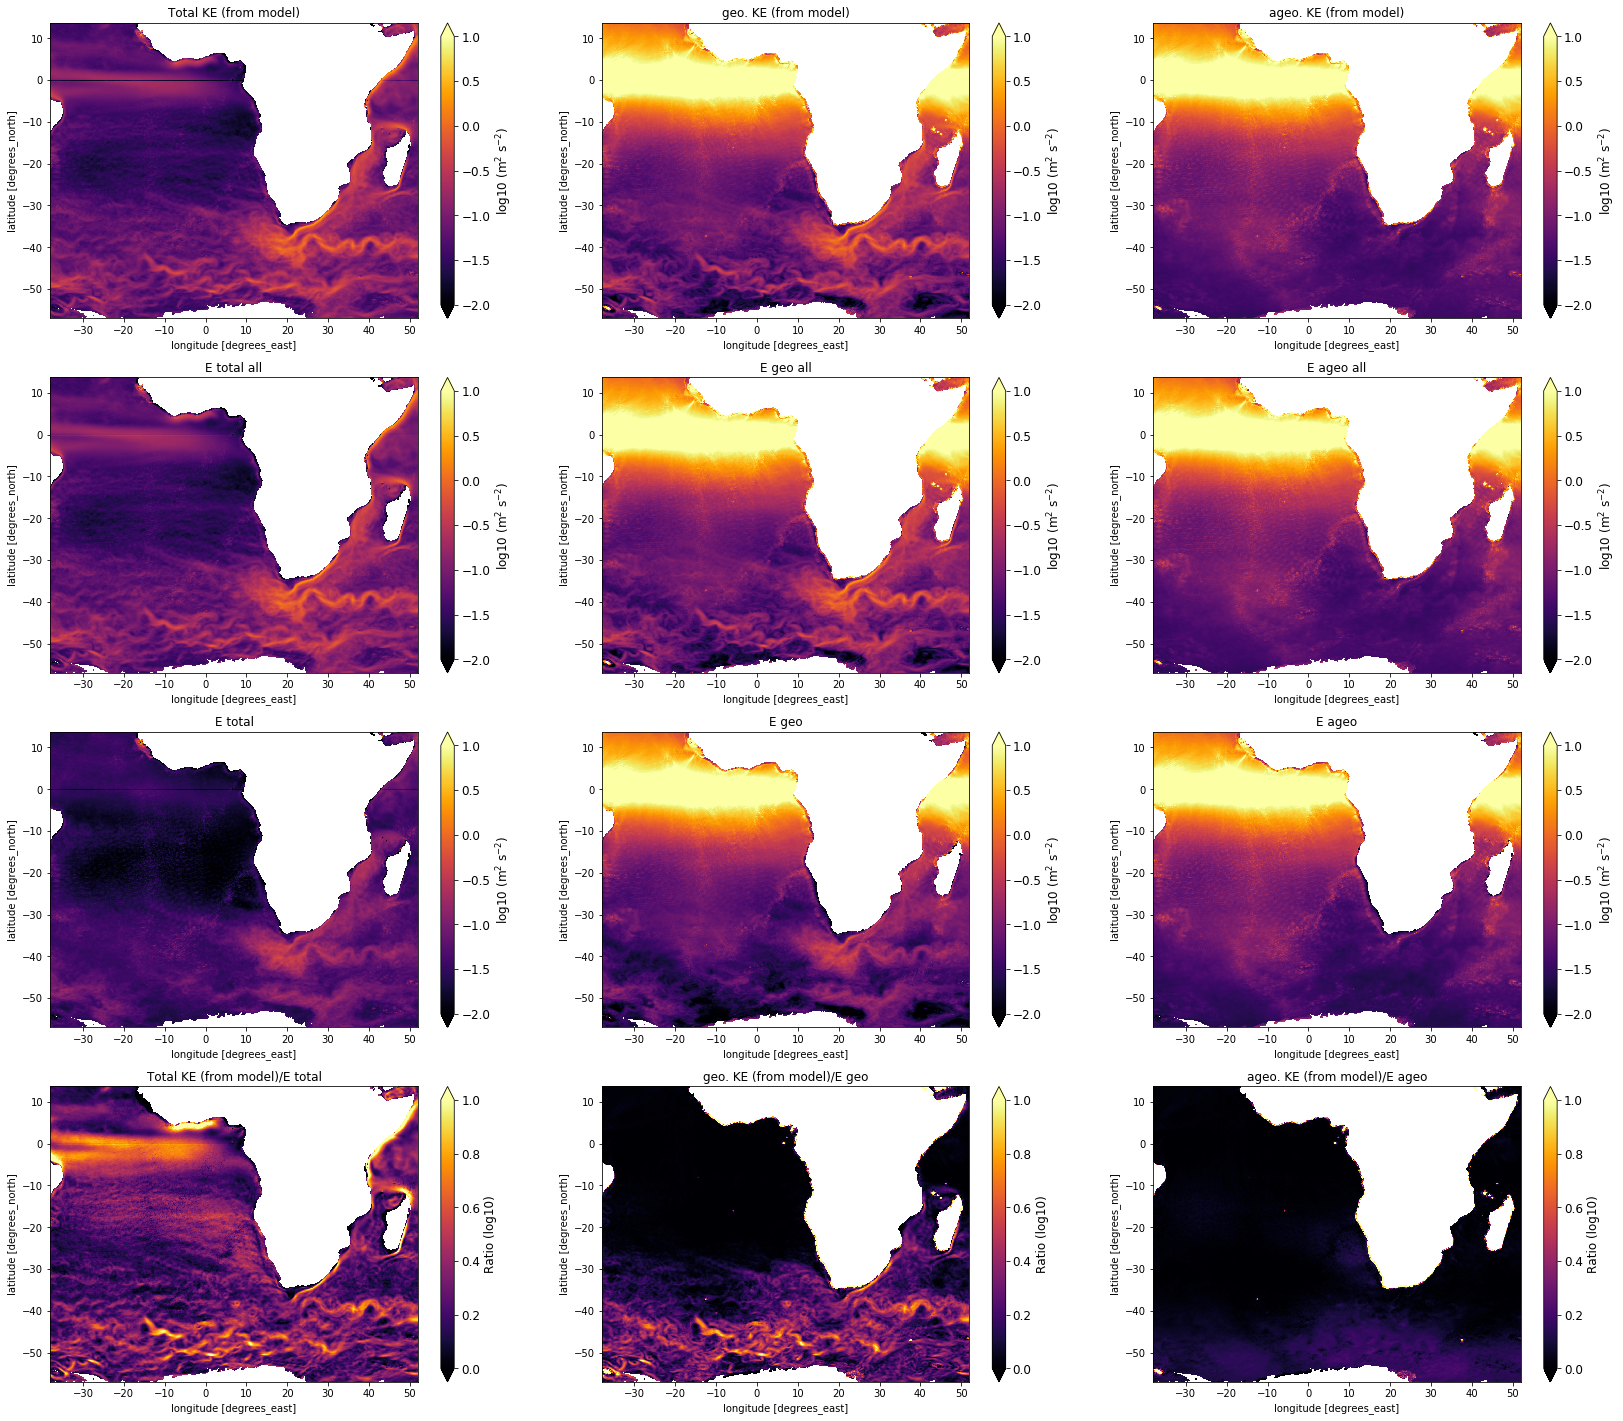

In [12]:
# in log scale
font_size = 12

fig, ax = plt.subplots(figsize = (28,25))

ax = plt.subplot(431)
cax=np.log10(u_mean.where(lice>0)+v_mean.where(lice>0)).plot(vmin=-2, vmax=1,x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('Total KE (from model)',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('log10 (m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(432)
cax=np.log10(u_geo_mean.where(lice>0)+v_geo_mean.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('geo. KE (from model)',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('log10 (m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(433)
cax=np.log10(u_ageo_mean.where(lice>0)+v_ageo_mean.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('ageo. KE (from model)',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('log10 (m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(434)
cax=np.log10(E_total_all.where(lice>0)).plot(vmin=-2, vmax=1,x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E total all',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('log10 (m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(435)
cax=np.log10(E_geo_all.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E geo all',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('log10 (m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(436)
cax=np.log10(E_ageo_all.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E ageo all',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('log10 (m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(437)
np.log10(E_total.where(lice>0)).plot(vmin=-2, vmax=1,x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E total',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('log10 (m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(438)
cax=np.log10(E_geo.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E geo',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('log10 (m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(439)
cax=np.log10(E_ageo.where(lice>0)).plot(vmin=-2, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E ageo',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('log10 (m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(4,3,10)
cax=np.log10( (u_mean.where(lice>0)+v_mean.where(lice>0))/E_total.where(lice>0) ).plot(vmin=0, vmax=1,x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('Total KE (from model)/E total',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio (log10)', fontsize=font_size)

ax = plt.subplot(4,3,11)
cax=np.log10( (u_geo_mean.where(lice>0)+v_geo_mean.where(lice>0))/E_geo.where(lice>0) ).plot(vmin=0, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('geo. KE (from model)/E geo',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio (log10)', fontsize=font_size)

ax = plt.subplot(4,3,12)
cax=np.log10( (u_ageo_mean.where(lice>0)+v_ageo_mean.where(lice>0))/E_ageo.where(lice>0) ).plot(vmin=0, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('ageo. KE (from model)/E ageo',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio (log10)', fontsize=font_size)


plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_AP_0326.png')

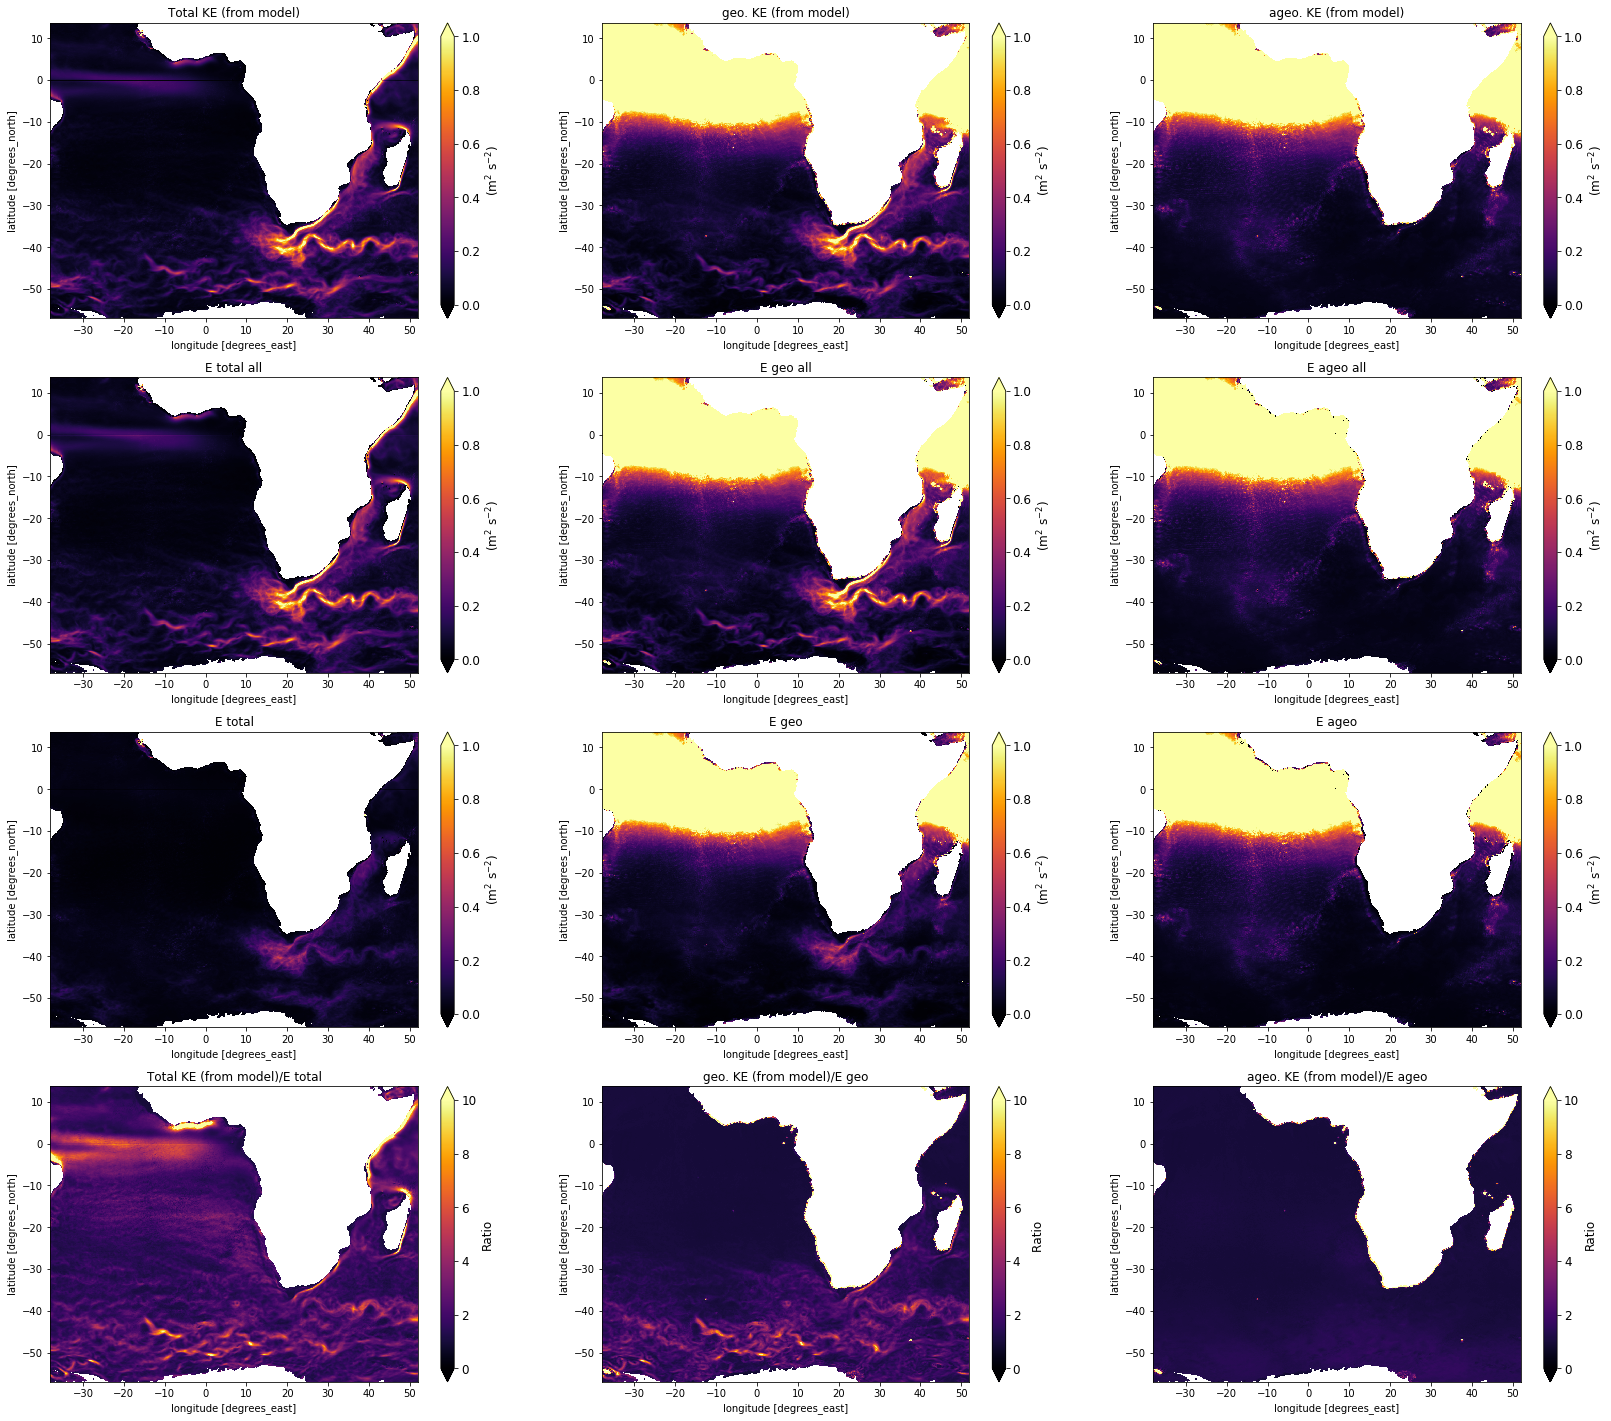

In [38]:
# in log scale
font_size = 12

fig, ax = plt.subplots(figsize = (28,25))

ax = plt.subplot(431)
cax=(u_mean.where(lice>0)+v_mean.where(lice>0)).plot(vmin=0, vmax=1,x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('Total KE (from model)',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(432)
cax=(u_geo_mean.where(lice>0)+v_geo_mean.where(lice>0)).plot(vmin=0, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('geo. KE (from model)',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(433)
cax=(u_ageo_mean.where(lice>0)+v_ageo_mean.where(lice>0)).plot(vmin=0, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('ageo. KE (from model)',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(434)
cax=(E_total_all.where(lice>0)).plot(vmin=0, vmax=1,x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E total all',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(435)
cax=(E_geo_all.where(lice>0)).plot(vmin=0, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E geo all',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(436)
cax=(E_ageo_all.where(lice>0)).plot(vmin=0, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E ageo all',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(437)
cax=(E_total.where(lice>0)).plot(vmin=0, vmax=1,x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E total',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(438)
cax=(E_geo.where(lice>0)).plot(vmin=0, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E geo',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(439)
cax=(E_ageo.where(lice>0)).plot(vmin=0, vmax=1, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('E ageo',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)

ax = plt.subplot(4,3,10)
cax=( (u_mean.where(lice>0)+v_mean.where(lice>0))/E_total.where(lice>0) ).plot(vmin=0, vmax=10,x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('Total KE (from model)/E total',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)

ax = plt.subplot(4,3,11)
cax=( (u_geo_mean.where(lice>0)+v_geo_mean.where(lice>0))/E_geo.where(lice>0) ).plot(vmin=0, vmax=10, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('geo. KE (from model)/E geo',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio ', fontsize=font_size)

ax = plt.subplot(4,3,12)
cax=( (u_ageo_mean.where(lice>0)+v_ageo_mean.where(lice>0))/E_ageo.where(lice>0) ).plot(vmin=0, vmax=10, x='XC', y='YC', cmap='inferno', add_colorbar = False)
ax.set_title('ageo. KE (from model)/E ageo',fontsize=font_size)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)

#plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_AP.png')

In [14]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=